# Finding Corners|

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

nx = 9
ny = 6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = './output_images/calibration_found_'+str(idx+1)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(200)
    else:
        print("Picture: ", idx+1, " Not Found")
cv2.destroyAllWindows()

Picture:  1  Not Found
Picture:  15  Not Found
Picture:  16  Not Found


# Test Undistortion

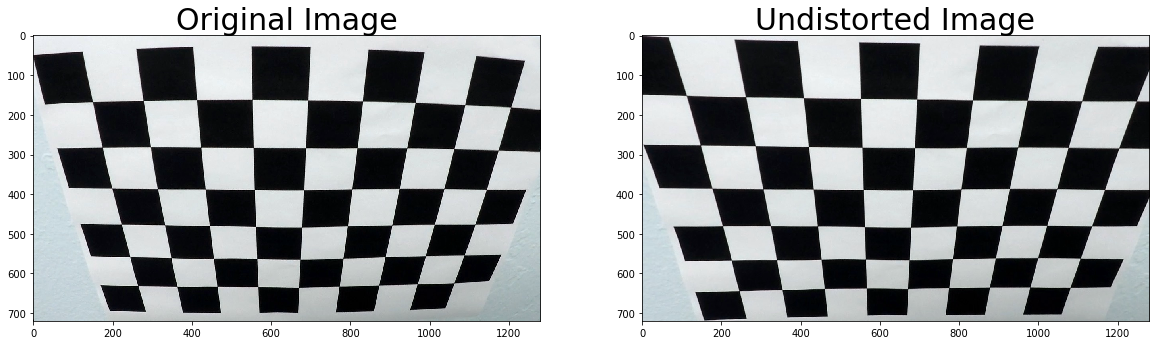

In [2]:
import pickle
%matplotlib inline

# Read in test image
img = cv2.imread('./camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])
# Do camera calibration and undistortion
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
# Save undistorted image
cv2.imwrite('./output_images/test_calibration1.jpg',dst)
# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( './output_images/test_mtx_dist_pickle.p',"wb"))
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

# Perspective Transform, Sobel Gradient and Color Space

In [3]:
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

dist_pickle = pickle.load( open( "./output_images/test_mtx_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
img = mpimg.imread('./output_images/test_frame_91.jpg')

def perspective_transform(image, mtx, dist, flag=1):
    img_size = (image.shape[1], img.shape[0])
    src = np.float32([[260, 680],
                    [1050, 680],
                    [590, 460],
                    [680, 460]])
    dst = np.float32([[260, 700],
                    [1020, 700],
                    [260, 50],
                    [1020, 50]])
    if flag == 1:
        undist = cv2.undistort(image, mtx, dist, None, mtx)
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
        return warped
    else:
        Minv = cv2.getPerspectiveTransform(dst, src)
        unwarped = cv2.warpPerspective(image, Minv, img_size, flags=cv2.INTER_LINEAR)
        return unwarped

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        orient_x = 1
        orient_y = 0
    else:
        orient_x = 0
        orient_y = 1
    # Calculate directional gradient
    sobel_results = cv2.Sobel(gray, cv2.CV_64F, orient_x, orient_y,  ksize = sobel_kernel)
    sobel_abs = np.absolute(sobel_results)
    sobel_scaled = np.uint8(255*sobel_abs/np.max(sobel_abs))
    # Apply threshold
    grad_binary = np.zeros_like(sobel_scaled)
    grad_binary[(sobel_scaled >= thresh[0]) & (sobel_scaled <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate gradient magnitude
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    sobel_mag = np.sqrt(sobel_x**2+ + sobel_y**2)
    sobel_scaled = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # Apply threshold
    mag_binary = np.zeros_like(sobel_scaled)
    mag_binary[(sobel_scaled >= thresh[0]) & (sobel_scaled <= thresh[1])] = 1
    return mag_binary

def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate gradient direction\
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    sobel_ang = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    # Apply threshold
    dir_binary = np.zeros_like(gray)
    dir_binary[(sobel_ang >= thresh[0]) & (sobel_ang <= [1])] = 1
    return dir_binary

def hls_thresh(image, thresh=(0, 255)):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

def rgb_thresh(image, thresh=(0, 255)):
    # Green channel
    g_channel = image[:,:,1]
    g_binary = np.zeros_like(g_channel)
    g_binary[(g_channel >= thresh[0]) & (g_channel <= thresh[1])] = 1
    return g_binary

# Sobel operator kernel size
ksize = 3
# Gradient threshold values
grad_thresh_min = 20
grad_thresh_max = 100
# Saturation channel threshold
s_thresh_min = 150
s_thresh_max = 255
# Gradient direction threshold
grad_dir_thresh_min = 0
grad_dir_thresh_max = np.pi/2

# Gradient X and Y
grad_x = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(grad_thresh_min, grad_thresh_max))
grad_y = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(grad_thresh_min, grad_thresh_max))
# Gradient Magnitude
grad_mag = mag_thresh(img, sobel_kernel=ksize, thresh=(grad_thresh_min, grad_thresh_max))
# Gradient Direction
grad_dir = dir_thresh(img, sobel_kernel=ksize, thresh=(grad_dir_thresh_min, grad_dir_thresh_max))
# Gradient Combined
combined_grad = np.zeros_like(grad_x)
combined_grad[((grad_x == 1) & (grad_y == 1)) | ((grad_mag == 1) & (grad_dir == 1))] = 1
# S Channel
s_channel = hls_thresh(img, thresh=(s_thresh_min, s_thresh_max))
# S Channel stacked with Graidient X
# stack_s_grad = np.dstack((np.zeros_like(grad_x), grad_x, s_channel))
# S Channel
g_channel = rgb_thresh(img, thresh=(s_thresh_min, s_thresh_max))
# S Channel combined with Graidient X
combined_s_grad = np.zeros_like(grad_x)
combined_s_grad[(grad_x == 1) | ((s_channel == 1) & (g_channel == 1))] = 1
# Warped Image
#warped_img = perspective_transform(img, mtx, dist,flag=1)
warped_img = perspective_transform(combined_s_grad, mtx, dist, flag=1)
# Save undistorted image
cv2.imwrite('./output_images/test_warped_image.jpg',warped_img)
# Post processing
warped_zeros = np.ones_like(warped_img)
warped_output = np.array(cv2.merge((warped_img*255,warped_img*255,warped_img*255)),np.uint8)
warped_zeros = np.array(cv2.merge((warped_zeros,warped_zeros,warped_zeros)),np.uint8)
cv2.line(warped_zeros, (300, 700), (300, 50),color=[255, 0, 0], thickness=10)
cv2.line(warped_zeros, (900, 700), (900, 50),color=[255, 0, 0], thickness=10)
warped_output = cv2.addWeighted(warped_output, 1.0, warped_zeros, 1.0, 0.0)

f, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(20,10))
cv2.line(img, (260, 680), (590, 450),color=[255, 0, 0], thickness=10)
cv2.line(img, (1050, 680), (680, 450),color=[255, 0, 0], thickness=10)
cv2.line(img, (590, 450), (680, 450),color=[255, 0, 0], thickness=10)
axes[0, 0].imshow(img)
axes[0, 0].plot(260, 680,'*')
axes[0, 0].plot(1050, 680,'*')
axes[0, 0].plot(590, 450,'*')
axes[0, 0].plot(680, 450,'*')
axes[0, 0].set_title('Original Image', fontsize=20)
axes[0, 1].imshow(warped_output)
axes[0, 1].set_title('Warped Image', fontsize=20)
axes[0, 2].imshow(grad_x)
axes[0, 2].set_title('Gradient X', fontsize=20)
axes[1, 0].imshow(grad_mag)
axes[1, 0].set_title('Gradient Mag', fontsize=20)
axes[1, 1].imshow(grad_dir)
axes[1, 1].set_title('Gradient Directional', fontsize=20)
axes[1, 2].imshow(combined_grad)
axes[1, 2].set_title('Gradient Combined', fontsize=20)
axes[2, 0].imshow(s_channel)
axes[2, 0].set_title('S Channel', fontsize=20)
axes[2, 1].imshow(g_channel)
axes[2, 1].set_title('G Channel', fontsize=20)
#axes[2, 1].imshow(s_channel)
#axes[2, 1].set_title('S Channel Stack with Gradient X', fontsize=20)
axes[2, 2].imshow(combined_s_grad, cmap='gray')
axes[2, 2].set_title('S Channel Combined with Gradient X', fontsize=20)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './output_images/test_frame_91.jpg'

# Sliding Window Search

In [ ]:
# Read in a thresholded image
warped = warped_img
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

conv_threshold = 1000 

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    # Add what we found for the first layer
    print(l_center,r_center,np.amax(np.convolve(window,l_sum)), np.amax(np.convolve(window,r_sum)))
    if np.amax(np.convolve(window,r_sum))> conv_threshold:
        if np.amax(np.convolve(window,l_sum))> conv_threshold:
            window_centroids.append((l_center,r_center))
        else:
            window_centroids.append((r_center-760,r_center))
    else:
        if np.amax(np.convolve(window,l_sum))> conv_threshold:
            window_centroids.append((l_center,l_center+760))
        else:
            window_centroids.append((260,1020))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]/2.0))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,image.shape[1]/2.0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        if np.amax(conv_signal[r_min_index:r_max_index])> conv_threshold:
            if np.amax(conv_signal[l_min_index:l_max_index])> conv_threshold:
                window_centroids.append((l_center,r_center))
            else:
                window_centroids.append((r_center-760,r_center))
        else:
            if np.amax(conv_signal[l_min_index:l_max_index])> conv_threshold:
                window_centroids.append((l_center,l_center + 760))
            else:
                 window_centroids.append( window_centroids[-1])
        print (window_centroids[-1])
        print(r_min_index,r_max_index)
    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    template_r = np.array(r_points,np.uint8) # left window pixels
    template_l = np.array(l_points,np.uint8) # left window pixels
    zero_channel = np.zeros_like(template) # create a zero color channel
    template_r = np.array(cv2.merge((zero_channel,zero_channel,template_r)),np.uint8) # make right window pixels blue
    template_l = np.array(cv2.merge((template_l,zero_channel,zero_channel)),np.uint8) # make left window pixels red
    warpage = np.array(cv2.merge((warped*255,warped*255,warped*255)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template_r+template_l, 0.8, 0.0) # overlay the orignal road image with window results
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
# Generate fitting curves
x_left_list = []
x_right_list = []
y_list = []
for idx, (x_left, x_right) in enumerate(window_centroids):
    x_left_list.append(x_left)
    x_right_list.append(x_right)
    y_list.append(idx*80.0+40.0)
x_left_array = np.asarray(x_left_list)[::-1]
x_right_array = np.asarray(x_right_list)[::-1]
y_array = np.asarray(y_list)
# Fit a second order polynomial to each
left_fit = np.polyfit(y_array, x_left_array, 2)
right_fit = np.polyfit(y_array, x_right_array, 2)
# Generate x and y values for plotting
ploty = np.linspace(0,warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# Right lane from weighted average
# right_fitx = right_fitx*0.5 + (left_fitx + warped.shape[1]/2.0 ) * 0.5
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()
# Maximum y-value is chosen to evaluate radius of curvature
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(y_array*ym_per_pix, x_left_array*xm_per_pix, 2)
right_fit_cr = np.polyfit(y_array*ym_per_pix, x_right_array*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm', (left_curverad+right_curverad)/2,'m')

unwarped_img = perspective_transform(output, mtx, dist, flag=2)
plt.imshow(unwarped_img)
plt.show()

# Preparation for Video

In [ ]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

dist_pickle = pickle.load( open( "./output_images/test_mtx_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Sobel operator kernel size
ksize = 3
# Gradient threshold values
grad_thresh_min = 20
grad_thresh_max = 100
# Saturation channel threshold
s_thresh_min = 150
s_thresh_max = 255
# Windows Search Parameters
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

conv_threshold = 1000 
list_average_fitting = [] # Add a list to store and evaluate the running average of the fitting parameters
list_max_len = 10

def perspective_transform(img, mtx, dist, flag=1):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[260, 680],
                    [1050, 680],
                    [590, 460],
                    [680, 460]])
    dst = np.float32([[260, 700],
                    [1020, 700],
                    [260, 50],
                    [1020, 50]])
    if flag == 1:
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
        return warped
    else:
        Minv = cv2.getPerspectiveTransform(dst, src)
        unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
        return unwarped

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        orient_x = 1
        orient_y = 0
    else:
        orient_x = 0
        orient_y = 1
    # Calculate directional gradient
    sobel_results = cv2.Sobel(gray, cv2.CV_64F, orient_x, orient_y,  ksize = sobel_kernel)
    sobel_abs = np.absolute(sobel_results)
    sobel_scaled = np.uint8(255*sobel_abs/np.max(sobel_abs))
    # Apply threshold
    grad_binary = np.zeros_like(sobel_scaled)
    grad_binary[(sobel_scaled >= thresh[0]) & (sobel_scaled <= thresh[1])] = 1
    return grad_binary

def hls_thresh(image, thresh=(0, 255)):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

def rgb_thresh(image, thresh=(0, 255)):
    # Green channel
    g_channel = image[:,:,1]
    g_binary = np.zeros_like(g_channel)
    g_binary[(g_channel >= thresh[0]) & (g_channel <= thresh[1])] = 1
    return g_binary

def warped_image(img):
    # Gradient X
    grad_x = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(grad_thresh_min, grad_thresh_max))
    # S Channel
    s_channel = hls_thresh(img, thresh=(s_thresh_min, s_thresh_max))
    g_channel = rgb_thresh(img, thresh=(s_thresh_min, s_thresh_max))
    # S Channel combined with Graidient X
    combined_s_grad = np.zeros_like(grad_x)
    combined_s_grad[(grad_x == 1) | ((s_channel == 1) & (g_channel == 1))] = 1
    # Warped Image
    warped_img = perspective_transform(combined_s_grad, mtx, dist, flag=1)
    return warped_img

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    # Add what we found for the first layer
    if np.amax(np.convolve(window,r_sum))> conv_threshold:
        if np.amax(np.convolve(window,l_sum))> conv_threshold:
            window_centroids.append((l_center,r_center))
        else:
            window_centroids.append((r_center-760,r_center))
    else:
        if np.amax(np.convolve(window,l_sum))> conv_threshold:
            window_centroids.append((l_center,l_center+760))
        else:
            window_centroids.append((260,1020))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]/2.0))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,image.shape[1]/2.0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        if np.amax(conv_signal[r_min_index:r_max_index])> conv_threshold:
            if np.amax(conv_signal[l_min_index:l_max_index])> conv_threshold:
                window_centroids.append((l_center,r_center))
            else:
                window_centroids.append((r_center-760,r_center))
        else:
            if np.amax(conv_signal[l_min_index:l_max_index])> conv_threshold:
                window_centroids.append((l_center,l_center + 760))
            else:
                 window_centroids.append(window_centroids[-1])
    return window_centroids

def process_image(img):
    # Read in a thresholded image
    warped = warped_image(img)
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        template_r = np.array(r_points,np.uint8) # left window pixels
        template_l = np.array(l_points,np.uint8) # left window pixels
        zero_channel = np.zeros_like(template) # create a zero color channel
        template_r = np.array(cv2.merge((zero_channel,zero_channel,template_r)),np.uint8) # make right window pixels blue
        template_l = np.array(cv2.merge((template_l,zero_channel,zero_channel)),np.uint8) # make left window pixels red
        output = cv2.addWeighted(template_r, 1, template_l, 1, 0.0) # overlay the orignal road image with window results
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    # Generate fitting curves
    x_left_list = []
    x_right_list = []
    y_list = []
    for idx, (x_left, x_right) in enumerate(window_centroids):
        x_left_list.append(x_left)
        x_right_list.append(x_right)
        y_list.append(idx*80.0+40.0)
    x_left_array = np.asarray(x_left_list)[::-1]
    x_right_array = np.asarray(x_right_list)[::-1]
    y_array = np.asarray(y_list)
    # Fit a second order polynomial to each
    left_fit = np.polyfit(y_array, x_left_array, 2)
    right_fit = np.polyfit(y_array, x_right_array, 2)
    # Adjusted fitting parameters for right lane
    if len(list_average_fitting)> list_max_len:
        list_average_fitting.pop(0)
        list_average_fitting.append((left_fit,right_fit))
    else:
        list_average_fitting.append((left_fit,right_fit))
    left_fit = 0
    right_fit = 0
    for i in range(len(list_average_fitting)):
        left_fit += list_average_fitting[i][0]
        right_fit += list_average_fitting[i][1]
    left_fit = left_fit/float(len(list_average_fitting))
    right_fit = right_fit/float(len(list_average_fitting))
    # Lane lines definition
    ploty = np.linspace(0,warped.shape[0]-1, warped.shape[0] )
    y_eval = np.max(ploty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    middle_fitx = (left_fitx[-1]+right_fitx[-1])/2.0
    offset_x = np.absolute(middle_fitx - img.shape[1]/2.0)
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    tot_pts = np.hstack((left_line, right_line))
    cv2.fillPoly(output, np.int_([tot_pts]), (0,255, 0))
    #plt.imshow(output)
    #plt.show()
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(y_array*ym_per_pix, x_left_array*xm_per_pix, 2)
    right_fit_cr = np.polyfit(y_array*ym_per_pix, x_right_array*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    curvature_str = 'Curvature: {0:.3f}m'.format((left_curverad+right_curverad)/2)
    offset_str = 'Offset from Center: {0:.3f}m'.format(offset_x*xm_per_pix)
    cv2.putText(img,curvature_str, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, color=(255,255,255),thickness=5)
    cv2.putText(img,offset_str, (100,150), cv2.FONT_HERSHEY_SIMPLEX, 2, color=(255,255,255),thickness=5)
    unwarped_output = perspective_transform(output, mtx, dist, flag=2)
    output_img = cv2.addWeighted(img, 1, unwarped_output, 0.5, 0.0)
    
    #warped_zeros = np.ones_like(warped)
    #warped_output = np.array(cv2.merge((warped*255,warped*255,warped*255)),np.uint8)
    #warped_zeros = np.array(cv2.merge((warped_zeros,warped_zeros,warped_zeros)),np.uint8)
    #warped_output = cv2.addWeighted(warped_output, 1.0, warped_zeros, 1.0, 0.0)
    #return warped_output
    return output_img

#images = glob.glob('./output_images/test_frame_*.jpg')
#for fname in images:
#    img_test = mpimg.imread(fname)
#    print(fname)
#img_test = mpimg.imread('./test_images/test17.jpg')
#    output_test = process_image(img_test)
#    plt.imshow(output_test)
#    plt.show()


# Video Processing

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
white_output = './output_images/test_output.mp4'
directory = os.path.dirname(white_output)
if not os.path.exists(directory):
    os.mkdir(directory)
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(38,43)
clip1 = VideoFileClip("project_video.mp4")
#for idx, frame in enumerate(clip1.iter_frames()):
#    output_file_name = './output_images/test_frame_'+str(idx)+'.jpg'
#    cv2.imwrite(output_file_name,cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))